이 노트북은 Oracle SQL Developer 환경에서 작성된 SQL 쿼리를 기반으로 하며, 다음과 같은 과정이 필요함:

- Oracle Database 설치 -> SQLite, MySQL에서는 RATIO_TO_REPORT, ROLLUP 같은 Oracle 전용 함수 미지원 -> 반드시 Oracle 환경에서 실행해야 함.
- DB에 사용자 및 스키마 생성 후 ETL.sql, DDL.sql 실행 -> 테이블 및 데이터 로드 완료 상태여야 함.
- DB 접속 정보 (user, password, host, port, service name)을 확인해야 함.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import oracledb
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

### CSV 파일 액세스

In [305]:
# 내 로컬 PC 경로
base_path = "C:/app/ojbs0/product/21c/oradata/table"

customers = pd.read_csv(f"{base_path}/customers.csv")
orders = pd.read_csv(f"{base_path}/orders.csv")
products = pd.read_csv(f"{base_path}/products.csv")
order_items = pd.read_csv(f"{base_path}/order_items.csv")
stores = pd.read_csv(f"{base_path}/stores.csv")
staffs = pd.read_csv(f"{base_path}/staffs.csv")
brands = pd.read_csv(f"{base_path}/brands.csv")
categories = pd.read_csv(f"{base_path}/categories.csv")
stocks = pd.read_csv(f"{base_path}/stocks.csv")

### 데이터 확인

In [306]:
print("Customers")
customers.head()

Customers


,customer_id,first_name,last_name,phone,email,street,city,state,zip_code
0,1,Debra,Burks,NaN,debra.burks@yahoo.com,9273 Thorne Ave.,Orchard Park,NY,14127
1,2,Kasha,Todd,NaN,kasha.todd@yahoo.com,910 Vine Street,Campbell,CA,95008
2,3,Tameka,Fisher,NaN,tameka.fisher@aol.com,769C Honey Creek St.,Redondo Beach,CA,90278
3,4,Daryl,Spence,NaN,daryl.spence@aol.com,988 Pearl Lane,Uniondale,NY,11553
4,5,Charolette,Rice,(916) 381-6003,charolette.rice@msn.com,107 River Dr.,Sacramento,CA,95820


In [307]:
print("Orders")
orders.head()

Orders


,order_id,customer_id,order_status,order_date,required_date,shipped_date,store_id,staff_id
0,1,259,4,2016-01-01,2016-01-03,2016-01-03,1,2
1,2,1212,4,2016-01-01,2016-01-04,2016-01-03,2,6
2,3,523,4,2016-01-02,2016-01-05,2016-01-03,2,7
3,4,175,4,2016-01-03,2016-01-04,2016-01-05,1,3
4,5,1324,4,2016-01-03,2016-01-06,2016-01-06,2,6


In [308]:
print("Order_items")
order_items.head()

Order_items


,order_id,item_id,product_id,quantity,list_price,discount
0,1,1,20,1,599.99,0.20
1,1,2,8,2,1799.99,0.07
2,1,3,10,2,1549.00,0.05
3,1,4,16,2,599.99,0.05
4,1,5,4,1,2899.99,0.20


In [309]:
print("stores")
stores.head()

stores


,store_id,store_name,phone,email,street,city,state,zip_code
0,1,Santa Cruz Bikes,(831) 476-4321,santacruz@bikes.shop,3700 Portola Drive,Santa Cruz,CA,95060
1,2,Baldwin Bikes,(516) 379-8888,baldwin@bikes.shop,4200 Chestnut Lane,Baldwin,NY,11432
2,3,Rowlett Bikes,(972) 530-5555,rowlett@bikes.shop,8000 Fairway Avenue,Rowlett,TX,75088


In [310]:
print("Staffs")
staffs.head()

Staffs


,staff_id,first_name,last_name,email,phone,active,store_id,manager_id
0,1,Fabiola,Jackson,fabiola.jackson@bikes.shop,(831) 555-5554,1,1,NaN
1,2,Mireya,Copeland,mireya.copeland@bikes.shop,(831) 555-5555,1,1,1.0
2,3,Genna,Serrano,genna.serrano@bikes.shop,(831) 555-5556,1,1,2.0
3,4,Virgie,Wiggins,virgie.wiggins@bikes.shop,(831) 555-5557,1,1,2.0
4,5,Jannette,David,jannette.david@bikes.shop,(516) 379-4444,1,2,1.0


In [311]:
print("Products")
products.head()

Products


,product_id,product_name,brand_id,category_id,model_year,list_price
0,1,Trek 820 - 2016,9,6,2016,379.99
1,2,Ritchey Timberwolf Frameset - 2016,5,6,2016,749.99
2,3,Surly Wednesday Frameset - 2016,8,6,2016,999.99
3,4,Trek Fuel EX 8 29 - 2016,9,6,2016,2899.99
4,5,Heller Shagamaw Frame - 2016,3,6,2016,1320.99


In [312]:
print("Stocks")
stocks.head()

Stocks


,store_id,product_id,quantity
0,1,1,27
1,1,2,5
2,1,3,6
3,1,4,23
4,1,5,22


In [313]:
print("Categories")
categories.head()

Categories


,category_id,category_name
0,1,Children Bicycles
1,2,Comfort Bicycles
2,3,Cruisers Bicycles
3,4,Cyclocross Bicycles
4,5,Electric Bikes


In [314]:
print("Brands")
brands.head()

Brands


,brand_id,brand_name
0,1,Electra
1,2,Haro
2,3,Heller
3,4,Pure Cycles
4,5,Ritchey


### Oracle DB 연결

In [315]:
# - user: DB 사용자 계정명 (예: 'bike')
# - password: 해당 계정 비밀번호
# - dsn: 접속 정보 (형식: "호스트명:포트/서비스명")
#   * 호스트명: 보통 localhost (원격 DB면 IP/도메인)
#   * 포트: 기본은 1521
#   * 서비스명: XE, XEPDB1 등 설치 환경에 맞는 서비스 이름


# 본인 환경에 맞게 수정하면 됨
conn = oracledb.connect(
    user="bike",
    password="bike",
    dsn="localhost:1521/XEPDB1"
)

## 📊 EDA

### 📊 EDA1: 브랜드별 매출 분포

In [316]:
query = '''
SELECT b.brand_name, 
       ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue,
       ROUND(RATIO_TO_REPORT(SUM(oi.quantity * oi.list_price * (1 - oi.discount))) OVER () * 100, 2) AS pct_of_revenue
FROM brands b
JOIN products p ON b.brand_id = p.brand_id
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY b.brand_name
ORDER BY 3 DESC, 2 DESC
'''

eda1 = pd.read_sql(query, conn)
eda1

,BRAND_NAME,REVENUE,PCT_OF_REVENUE
0,Trek,4602754.35,59.86
1,Electra,1205320.82,15.68
2,Surly,949507.06,12.35
3,Sun Bicycles,341994.93,4.45
4,Haro,185384.55,2.41
5,Heller,171459.08,2.23
6,Pure Cycles,149476.34,1.94
7,Ritchey,78898.95,1.03
8,Strider,4320.48,0.06


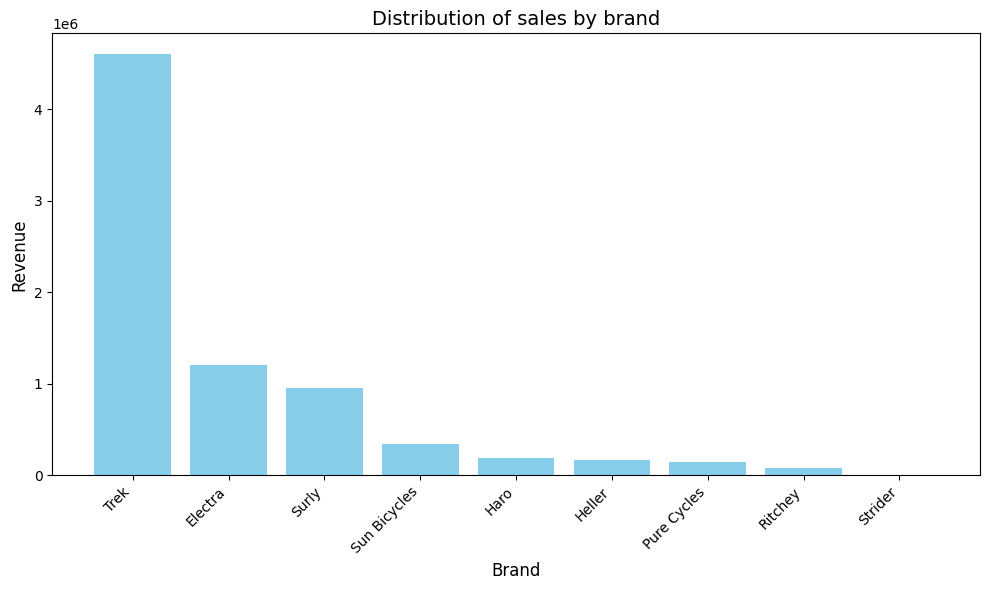

In [317]:
plt.figure(figsize=(10,6))

plt.bar(eda1["BRAND_NAME"], eda1["REVENUE"], color="skyblue")

plt.title("Distribution of sales by brand", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

- Trek 브랜드가 전체 매출의 60%를 차지하며, Electra(16%), Surly(12%)가 뒤를 이음.  
- 나머지 브랜드는 합쳐서 12%의 매출 비중을 보임.

### 📊 EDA2: 가격대 구간별 매출

In [318]:
query = '''
WITH brand_price AS (
    SELECT p.brand_id,
           AVG(p.list_price) AS avg_price
    FROM products p
    GROUP BY p.brand_id
), brand_revenue AS (
    SELECT  p.brand_id,
            ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue
    FROM    order_items oi
    JOIN    products p ON oi.product_id = p.product_id
    GROUP BY p.brand_id
), price_percentiles AS (
    SELECT 
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY avg_price) AS p25,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY avg_price) AS p75
    FROM brand_price
)
SELECT  b.brand_name,
        ROUND(bp.avg_price, 2) AS avg_price,
        br.revenue,
        CASE
            WHEN bp.avg_price < (SELECT p25 FROM price_percentiles) THEN 'Low'
            WHEN bp.avg_price <= (SELECT p75 FROM price_percentiles) THEN 'Mid'
            ELSE 'High'
        END AS price_tier
FROM    brand_price bp
JOIN    brand_revenue br ON bp.brand_id = br.brand_id
JOIN    brands b ON bp.brand_id = b.brand_id
ORDER BY 3 DESC, 2
'''
eda2 = pd.read_sql(query, conn)
eda2

,BRAND_NAME,AVG_PRICE,REVENUE,PRICE_TIER
0,Trek,2500.06,4602754.35,High
1,Electra,761.01,1205320.82,Mid
2,Surly,1331.75,949507.06,Mid
3,Sun Bicycles,524.47,341994.93,Mid
4,Haro,621.99,185384.55,Mid
5,Heller,2173.00,171459.08,High
6,Pure Cycles,442.33,149476.34,Low
7,Ritchey,749.99,78898.95,Mid
8,Strider,209.99,4320.48,Low


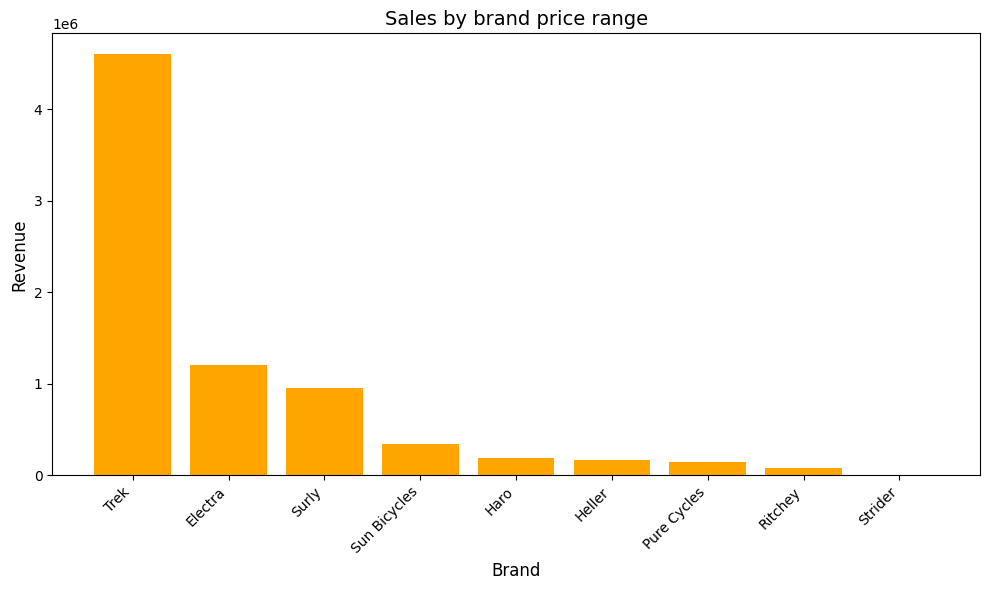

In [319]:
plt.figure(figsize=(10,6))
plt.bar(eda2["BRAND_NAME"], eda2["REVENUE"], color="orange")
plt.title("Sales by brand price range", fontsize=14)
plt.xlabel("Brand", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

- High Tier: Trek은 고가이면서 매출 압도적 1위, Heller는 고가지만 매출 중간 수준.

- Mid Tier: Electra, Surly 등 고르게 분포.

- Low Tier: Strider는 최저가이나 매출 최하위, Pure Cycles는 저가지만 상대적으로 매출 선방.

### 📊 EDA3: 브랜드별 분기 매출 추이

In [320]:
query = '''
WITH order_season AS (
    SELECT  order_id,
            '20' || SUBSTR(order_date, 1, 2) AS year,
            SUBSTR(order_date, 4, 2) AS month,
            CASE 
                WHEN SUBSTR(order_date, 4, 2) IN ('01','02','03') THEN 1
                WHEN SUBSTR(order_date, 4, 2) IN ('04','05','06') THEN 2
                WHEN SUBSTR(order_date, 4, 2) IN ('07','08','09') THEN 3
                ELSE 4
            END AS season
    FROM    orders
)
SELECT  b.brand_name, 
        os.year, 
        os.season,
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue,
        ROUND(RATIO_TO_REPORT(SUM(oi.quantity * oi.list_price * (1 - oi.discount)))  
            OVER (PARTITION BY b.brand_name) * 100, 2) AS pct_of_revenue
FROM    order_season os
JOIN    order_items oi ON os.order_id = oi.order_id
JOIN    products p ON oi.product_id = p.product_id
JOIN    brands b ON p.brand_id = b.brand_id
GROUP BY b.brand_name, os.year, os.season
ORDER BY 1, 2, 3
'''
eda3 = pd.read_sql(query, conn)
eda3

,BRAND_NAME,YEAR,SEASON,REVENUE,PCT_OF_REVENUE
0,Electra,2016,1,136603.18,11.33
1,Electra,2016,2,103997.36,8.63
2,Electra,2016,3,136121.92,11.29
3,Electra,2016,4,130567.33,10.83
4,Electra,2017,1,91837.85,7.62
...,...,...,...,...,...
77,Trek,2017,4,571303.73,12.41
78,Trek,2018,1,660061.51,14.34
79,Trek,2018,2,555891.88,12.08
80,Trek,2018,3,19248.91,0.42


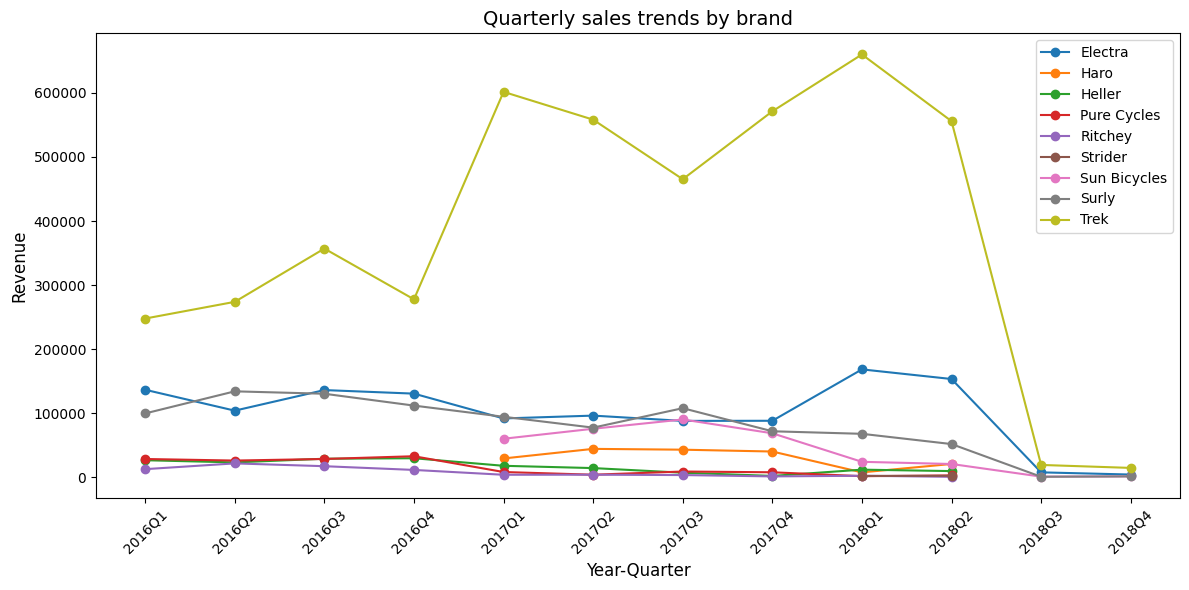

In [321]:
plt.figure(figsize=(12,6))
for brand in eda3["BRAND_NAME"].unique():
    brand_data = eda3[eda3["BRAND_NAME"] == brand]
    plt.plot(brand_data["YEAR"].astype(str) + "Q" + brand_data["SEASON"].astype(str),
             brand_data["REVENUE"], marker="o", label=brand)

plt.title("Quarterly sales trends by brand", fontsize=14)
plt.xlabel("Year-Quarter", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

- Trek은 연중 안정적 매출 유지, 2017~2018 상승세 뚜렷.

- Electra·Surly는 특정 분기 반짝 매출, 이후 급락.

- Sun Bicycles는 2017년 Q3에 최고 매출, 이후 급감.

### 📊 EDA4: 한 번만 구매한 고객 vs 재구매한 고객의 매출 기여도 차이

In [322]:
query = '''
WITH customer_purchase_count AS (
    SELECT  order_id,
            customer_id,
            CASE
                WHEN MAX(rn) OVER (PARTITION BY customer_id) = 1 THEN 'one'
                ELSE 'repeat'
            END AS customer_type
    FROM    (
        SELECT  order_id,
                customer_id,
                ROW_NUMBER () OVER (PARTITION BY customer_id ORDER BY order_date) AS rn
        FROM    orders
    )
)
SELECT  cpc.customer_type, 
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue,
        ROUND(RATIO_TO_REPORT (SUM(oi.quantity * oi.list_price * (1 - oi.discount))) OVER (), 2) AS pct_of_revenue
FROM    customer_purchase_count cpc
JOIN    order_items oi
ON      cpc.order_id = oi.order_id
GROUP BY cpc.customer_type
'''
eda4 = pd.read_sql(query, conn)
eda4

,CUSTOMER_TYPE,REVENUE,PCT_OF_REVENUE
0,one,5996361.94,0.78
1,repeat,1692754.61,0.22


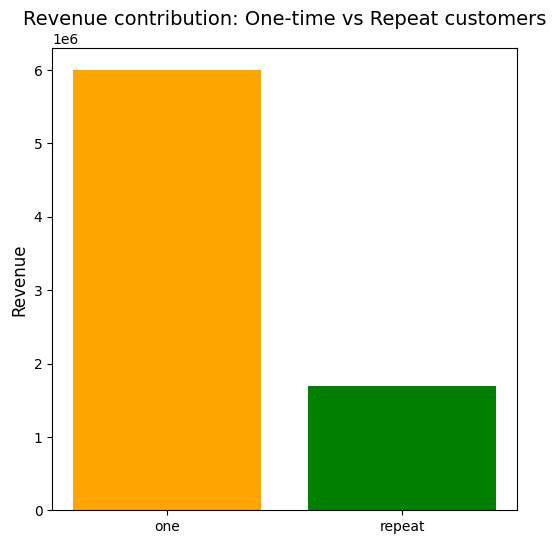

In [323]:
plt.figure(figsize=(6,6))
plt.bar(eda4["CUSTOMER_TYPE"], eda4["REVENUE"], color=["orange","green"])
plt.title("Revenue contribution: One-time vs Repeat customers", fontsize=14)
plt.ylabel("Revenue", fontsize=12)
plt.show()

- 신규 고객(one-time)이 전체 매출 기여도가 월등히 높음.

- 재구매 고객(repeat)은 상대적으로 낮은 기여도를 보임.

### 📊 EDA5: 브랜드 매장별 같은 위치에 사는 고객 비율

In [324]:
query = '''
WITH customer_store_match AS (
    SELECT  o.order_id,
            o.customer_id,
            s.store_id,
            s.city   AS store_city,
            s.state  AS store_state,
            c.city   AS cust_city,
            c.state  AS cust_state,
            CASE 
                WHEN s.city = c.city AND s.state = c.state THEN 1 
                ELSE 0 
            END AS same_location
    FROM    orders o
    JOIN    customers c 
    ON      o.customer_id = c.customer_id
    JOIN    stores s    
    ON      o.store_id = s.store_id
),
brand_customer_location AS (
    SELECT  b.brand_name,
            cs.same_location
    FROM    customer_store_match cs
    JOIN    order_items oi 
    ON      cs.order_id = oi.order_id
    JOIN    products p     
    ON      oi.product_id = p.product_id
    JOIN    brands b       
    ON      p.brand_id = b.brand_id
)
SELECT  brand_name,
        COUNT(*) AS total_orders,
        SUM(same_location) AS same_location_orders,
        ROUND(SUM(same_location) * 100.0 / COUNT(*), 2) AS pct_same_location
FROM    brand_customer_location
GROUP BY brand_name
ORDER BY pct_same_location DESC
'''
eda5 = pd.read_sql(query, conn)
eda5

,BRAND_NAME,TOTAL_ORDERS,SAME_LOCATION_ORDERS,PCT_SAME_LOCATION
0,Ritchey,77,2,2.60
1,Surly,605,15,2.48
2,Electra,1729,27,1.56
3,Trek,1235,18,1.46
4,Haro,220,3,1.36
5,Sun Bicycles,485,6,1.24
6,Pure Cycles,258,3,1.16
7,Strider,16,0,0.00
8,Heller,97,0,0.00


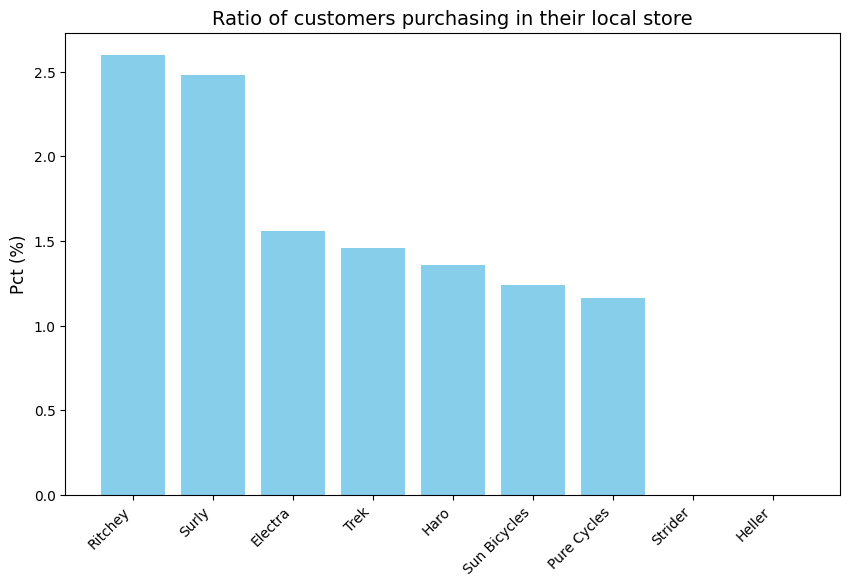

In [325]:
plt.figure(figsize=(10,6))
plt.bar(eda5["BRAND_NAME"], eda5["PCT_SAME_LOCATION"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.title("Ratio of customers purchasing in their local store", fontsize=14)
plt.ylabel("Pct (%)", fontsize=12)
plt.show()

- 브랜드별 매출은 매장-고객의 물리적 위치와 큰 상관성이 없음.

### 📊 EDA6: 브랜드별 평균 할인 비율

In [326]:
query = '''
SELECT  b.brand_name, 
        ROUND(AVG(oi.discount), 2) AS avg_discount_rate
FROM    order_items oi
JOIN    products p
ON      oi.product_id = p.product_id
JOIN    brands b
ON      p.brand_id = b.brand_id
GROUP BY b.brand_name
'''
eda6 = pd.read_sql(query, conn)
eda6

,BRAND_NAME,AVG_DISCOUNT_RATE
0,Electra,0.10
1,Trek,0.11
2,Surly,0.11
3,Ritchey,0.11
4,Pure Cycles,0.10
5,Heller,0.11
6,Haro,0.11
7,Sun Bicycles,0.11
8,Strider,0.12


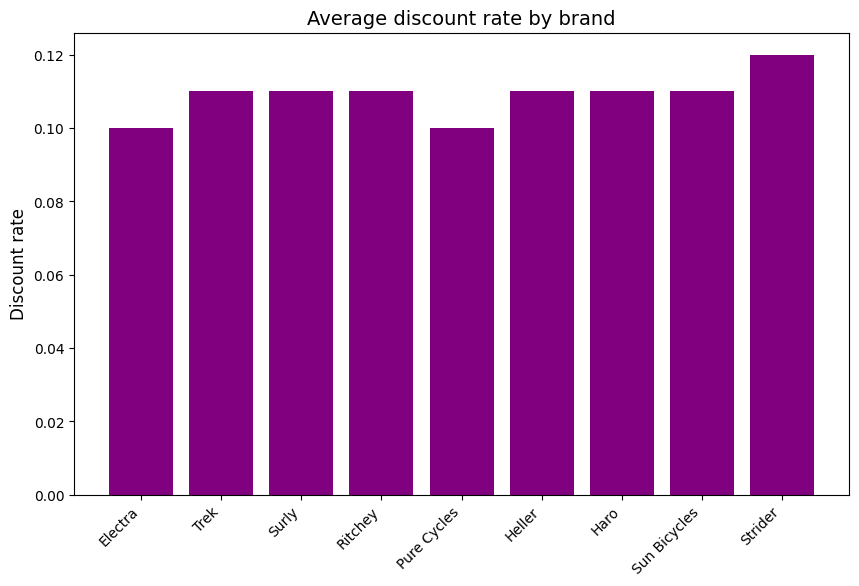

In [327]:
plt.figure(figsize=(10,6))
plt.bar(eda6["BRAND_NAME"], eda6["AVG_DISCOUNT_RATE"], color="purple")
plt.xticks(rotation=45, ha="right")
plt.title("Average discount rate by brand", fontsize=14)
plt.ylabel("Discount rate", fontsize=12)
plt.show()

- 브랜드별 할인율은 크게 차이나지 않음.

### 📊 EDA7: 카테고리별 매출 집중도

In [328]:
query = '''
SELECT  c.category_name,
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue,
        ROUND(RATIO_TO_REPORT (SUM(oi.quantity * oi.list_price * (1 - oi.discount)))  
            OVER () * 100, 2) 
        AS pct_of_revenue
FROM    order_items oi
JOIN    products p
ON      oi.product_id = p.product_id
JOIN    categories c
ON      p.category_id = c.category_id
GROUP BY c.category_name
ORDER BY 3 DESC
'''
eda7 = pd.read_sql(query, conn)
eda7

,CATEGORY_NAME,REVENUE,PCT_OF_REVENUE
0,Mountain Bikes,2715079.53,35.31
1,Road Bikes,1665098.49,21.66
2,Cruisers Bicycles,995032.62,12.94
3,Electric Bikes,916684.78,11.92
4,Cyclocross Bicycles,711011.84,9.25
5,Comfort Bicycles,394020.10,5.12
6,Children Bicycles,292189.20,3.80


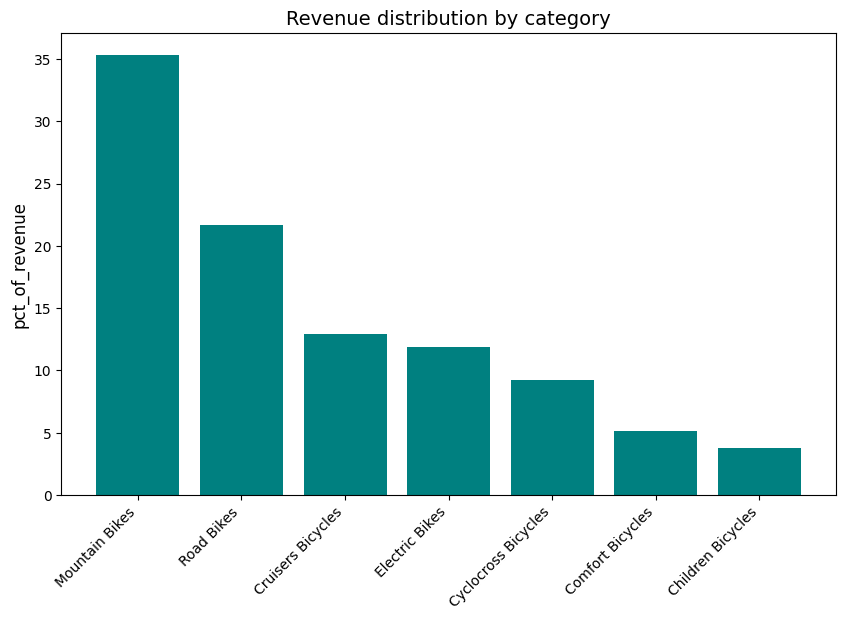

In [329]:
plt.figure(figsize=(10,6))
plt.bar(eda7["CATEGORY_NAME"], eda7["PCT_OF_REVENUE"], color="teal")
plt.xticks(rotation=45, ha="right")
plt.title("Revenue distribution by category", fontsize=14)
plt.ylabel("pct_of_revenue", fontsize=12)
plt.show()

- Mountain Bikes(35%)와 Road Bikes(22%)가 매출의 절반 이상을 차지.

### 📊 EDA8: 분기별 카테고리별 매출 추이

In [ ]:
query = '''
WITH order_season AS (
    SELECT  o.order_id,
            '20' || SUBSTR(o.order_date, 1, 2) AS year,
            CASE 
                WHEN SUBSTR(o.order_date, 4, 2) IN ('01','02','03') THEN 1
                WHEN SUBSTR(o.order_date, 4, 2) IN ('04','05','06') THEN 2
                WHEN SUBSTR(o.order_date, 4, 2) IN ('07','08','09') THEN 3
                ELSE 4
            END AS season
    FROM    orders o
)
SELECT  c.category_name,
        os.year,
        os.season,
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue,
        ROUND(RATIO_TO_REPORT(SUM(oi.quantity * oi.list_price * (1 - oi.discount)))
              OVER (PARTITION BY c.category_name) * 100, 2) AS pct_revenue
FROM    order_items oi
JOIN    products p ON oi.product_id = p.product_id
JOIN    categories c ON p.category_id = c.category_id
JOIN    order_season os ON oi.order_id = os.order_id
GROUP BY c.category_name, os.year, os.season
ORDER BY c.category_name, os.year, os.season
'''

eda8 = pd.read_sql(query, conn)
eda8

,CATEGORY_NAME,YEAR,SEASON,REVENUE,PCT_REVENUE
0,Children Bicycles,2016,1,24260.74,8.30
1,Children Bicycles,2016,2,15697.53,5.37
2,Children Bicycles,2016,3,23294.47,7.97
3,Children Bicycles,2016,4,24428.13,8.36
4,Children Bicycles,2017,1,40930.24,14.01
...,...,...,...,...,...
72,Road Bikes,2017,4,237224.55,14.25
73,Road Bikes,2018,1,322577.45,19.37
74,Road Bikes,2018,2,274635.02,16.49
75,Road Bikes,2018,3,10879.97,0.65


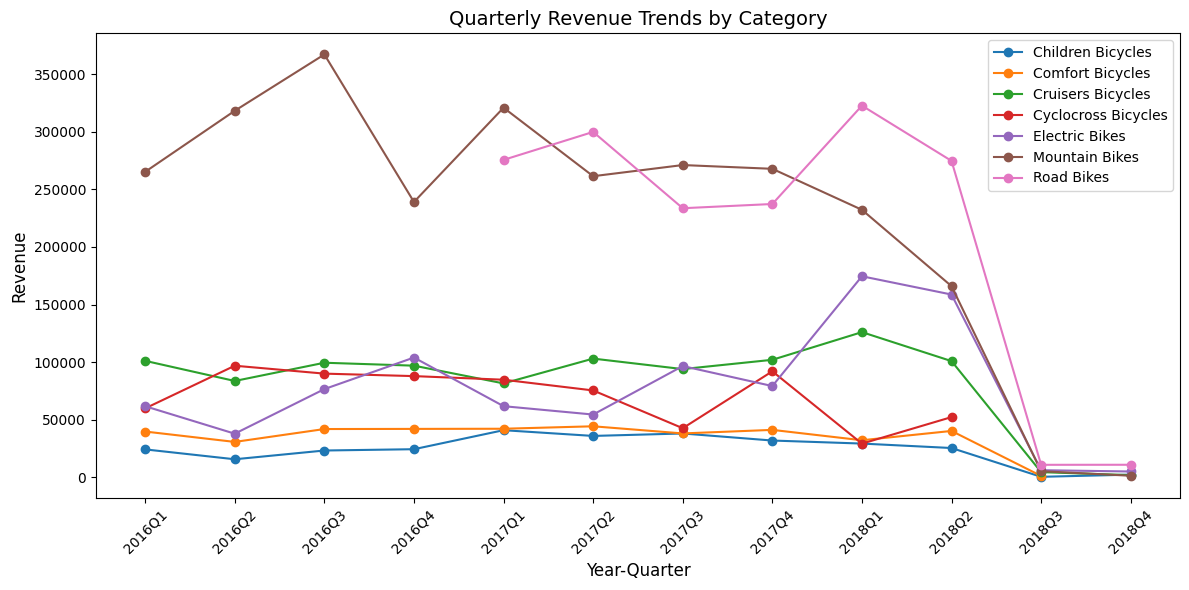

In [ ]:
plt.figure(figsize=(12,6))

for category in eda8["CATEGORY_NAME"].unique():
    cat_data = eda8[eda8["CATEGORY_NAME"] == category]
    x_labels = cat_data["YEAR"].astype(str) + "Q" + cat_data["SEASON"].astype(str)

    plt.plot(x_labels, cat_data["REVENUE"], marker="o", label=category)

plt.title("Quarterly Revenue Trends by Category", fontsize=14)
plt.xlabel("Year-Quarter", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

- Mountain Bikes / Road Bikes: 전체 매출을 압도적으로 견인하는 주력 카테고리, 시즌별로 등락은 있으나 꾸준히 상위권 유지.

- Electric Bikes: 2017~2018년 들어 매출이 빠르게 성장하면서 새로운 성장동력으로 작용.

- Cyclocross Bicycles: 특정 시즌(Q2, Q4)에만 매출이 튀는 형태 -> 전형적인 시즌성 제품.

- Children / Comfort Bicycles: 상대적으로 안정적이지만 매출 규모는 작은 편.

### 📊 EDA9: 고객 지역(주/도시)별 매출 분포

In [ ]:
query = '''
SELECT  c.state,
        c.city,
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue,
        ROUND(RATIO_TO_REPORT(SUM(oi.quantity * oi.list_price * (1 - oi.discount))) 
              OVER (PARTITION BY c.state) * 100, 2) AS pct_in_state
FROM    customers c
JOIN    orders o 
ON      c.customer_id = o.customer_id
JOIN    order_items oi
ON      o.order_id = oi.order_id
GROUP BY c.state, c.city
ORDER BY 1, 4 DESC
'''
eda9 = pd.read_sql(query, conn)
eda9

,STATE,CITY,REVENUE,PCT_IN_STATE
0,CA,Canyon Country,86520.53,5.39
1,CA,Palos Verdes Peninsula,74642.20,4.65
2,CA,South El Monte,69111.57,4.30
3,CA,San Jose,67201.75,4.18
4,CA,Duarte,62667.37,3.90
...,...,...,...,...
190,TX,Helotes,17671.27,2.04
191,TX,Amarillo,11691.62,1.35
192,TX,Mcallen,5635.73,0.65
193,TX,San Antonio,4344.98,0.50


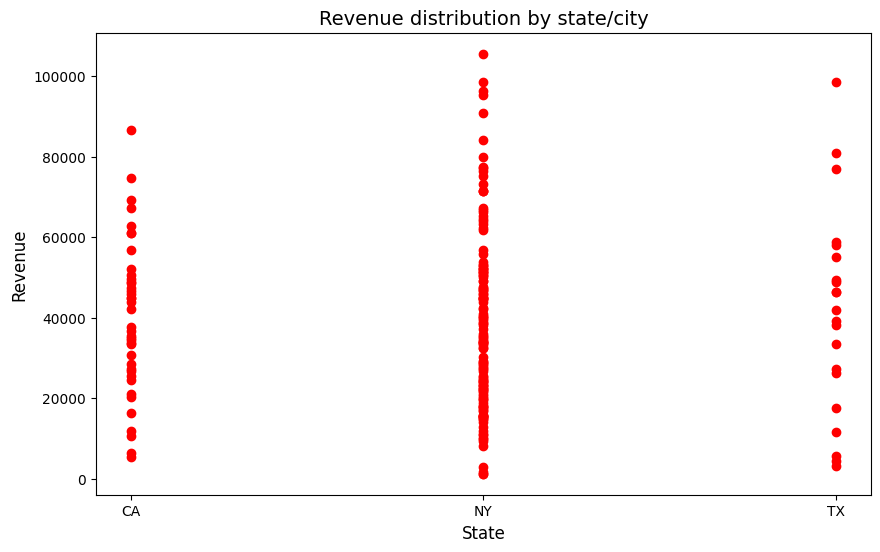

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(eda9["STATE"], eda9["REVENUE"], color="red")
plt.title("Revenue distribution by state/city", fontsize=14)
plt.xlabel("State", fontsize=12)
plt.ylabel("Revenue", fontsize=12)
plt.show()

- CA는 도시별로 매출 분산, TX는 특정 도시 집중, NY는 고르게 분포된 형태.

### 📊 EDA10: 고객별 평균 구매 단가/장바구니 크기

In [ ]:
query = '''
SELECT  c.customer_id, 
        COUNT(DISTINCT o.order_id) AS order_count,
        ROUND(AVG(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS avg_order_value,
        ROUND(AVG(oi.quantity)) AS avg_cart_size
FROM    order_items oi
JOIN    orders o
ON      oi.order_id = o.order_id
JOIN    customers c
ON      o.customer_id = c.customer_id
GROUP BY c.customer_id
ORDER BY 1
'''
eda10 = pd.read_sql(query, conn)
eda10

,CUSTOMER_ID,ORDER_COUNT,AVG_ORDER_VALUE,AVG_CART_SIZE
0,1,3,2535.29,2
1,2,3,1932.91,2
2,3,3,1850.12,1
3,4,3,2350.10,1
4,5,3,2190.04,2
...,...,...,...,...
1440,1441,1,3057.79,1
1441,1442,1,1397.45,2
1442,1443,1,2074.42,1
1443,1444,1,699.99,2


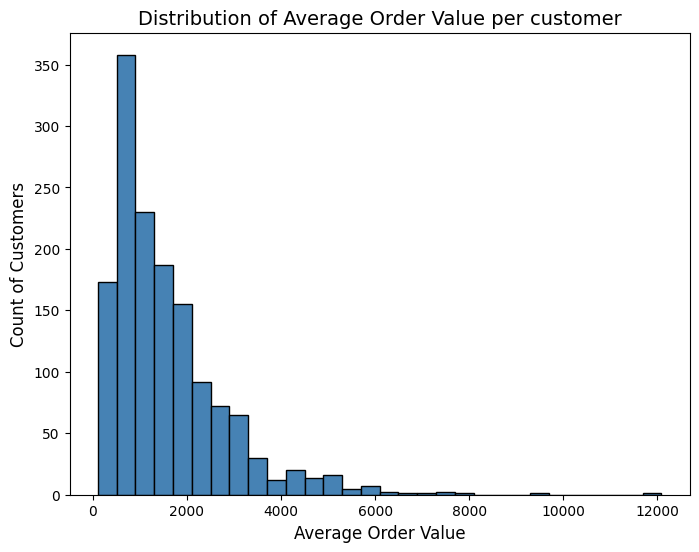

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(eda10["AVG_ORDER_VALUE"], bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Average Order Value per customer", fontsize=14)
plt.xlabel("Average Order Value", fontsize=12)
plt.ylabel("Count of Customers", fontsize=12)
plt.show()

- 고객별 평균 장바구니 크기(cart size)는 비교적 작고, 주문 단가가 고가 브랜드 유무에 따라 분포 차이를 보임.

## 📊 Hypothesis

### 📊 Hypothesis1: 고가 브랜드는 연중 꾸준히 매출을 유지하지만, 중가 브랜드는 특정 시즌에 집중적으로 매출이 발생하며, 이 시즌에서의 매출 상승 폭은 신규 고객보다는 기존 고객이 더 크게 기여한다.

In [334]:
query = '''
WITH brand_price AS (
    SELECT p.brand_id,
           AVG(p.list_price) AS avg_price
    FROM products p
    GROUP BY p.brand_id
), price_percentiles AS (
    SELECT 
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY avg_price) AS p25,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY avg_price) AS p75
    FROM brand_price
), brand_tier AS (
    SELECT bp.brand_id,
           CASE 
             WHEN bp.avg_price < (SELECT p25 FROM price_percentiles) THEN 'Low'
             WHEN bp.avg_price <= (SELECT p75 FROM price_percentiles) THEN 'Mid'
             ELSE 'High'
           END AS tier
    FROM brand_price bp
), first_orders AS (
    SELECT customer_id,
           MIN(order_date) AS first_order_date
    FROM orders
    GROUP BY customer_id
), customer_orders AS (
    SELECT o.order_id,
           o.customer_id,
           o.order_date,
           CASE WHEN o.order_date = f.first_order_date 
                THEN 'New'
                ELSE 'Existing'
           END AS customer_type
    FROM orders o
    JOIN first_orders f 
    ON   o.customer_id = f.customer_id
), order_season AS (
    SELECT  order_id,
            CASE 
                WHEN SUBSTR(order_date, 4, 2) IN ('01','02','03') THEN 1
                WHEN SUBSTR(order_date, 4, 2) IN ('04','05','06') THEN 2
                WHEN SUBSTR(order_date, 4, 2) IN ('07','08','09') THEN 3
                ELSE 4
            END AS season
    FROM orders
)
SELECT  
        CASE WHEN GROUPING(bt.tier) = 1 THEN 'TOTAL_TIERS' ELSE bt.tier END AS tier,
        CASE WHEN GROUPING(co.customer_type) = 1 THEN 'TOTAL_CUSTOMERS' ELSE co.customer_type END AS customer_type,
        CASE WHEN GROUPING(os.season) = 1 THEN 'TOTAL_SEASONS' ELSE TO_CHAR(os.season) END AS season,
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount))) AS revenue
FROM    order_items oi
JOIN    products p     
ON      oi.product_id = p.product_id
JOIN    brand_tier bt  
ON      p.brand_id = bt.brand_id
JOIN    customer_orders co 
ON      oi.order_id = co.order_id
JOIN    order_season os   
ON      oi.order_id = os.order_id
WHERE   bt.tier IN ('High','Mid')
GROUP BY ROLLUP (bt.tier, co.customer_type, os.season)
ORDER BY 1, 2, 3
'''

result1 = pd.read_sql(query, conn)
result1

,TIER,CUSTOMER_TYPE,SEASON,REVENUE
0,High,Existing,1,28227
1,High,Existing,2,575529
2,High,Existing,3,42331
3,High,Existing,4,34933
4,High,Existing,TOTAL_SEASONS,681020
5,High,New,1,1537685
6,High,New,2,859670
7,High,New,3,835253
8,High,New,4,860584
9,High,New,TOTAL_SEASONS,4093193


# 분석

## 1. High Tier (고가 브랜드)

-- 총 매출: 약 4.77M (전체의 ~63%)


### Existing 고객

-- 합계: 681K (High Tier의 14% 수준)
-- Q2에서 **575K (84%)**로 압도적으로 몰림
-- 나머지 분기(Q1/Q3/Q4)는 각 3~5% 수준

-- 기존 고객은 특정 시즌(2분기)에만 집중적으로 소비하고, 나머지 시즌에는 활동이 미미함.


### New 고객

-- 합계: 4.09M (High Tier의 86%)
-- Q1~Q4에 고르게 분포 (15~21%씩)
-- Q1은 1.54M으로 가장 큼

-- 신규 고객이 연중 고르게 분포된 매출을 견인, 고가 브랜드의 주 매출원 역할.



## 2. Mid Tier (중가 브랜드)


-- 총 매출: 약 2.76M (전체의 ~37%)


### Existing 고객

- 합계: 330K (Mid Tier의 12%)
- Q2에서 **256K (78%)**로 몰림
- 나머지 분기(Q1/Q3/Q4)는 합쳐도 70K (22%)

-- 기존 고객 매출이 High Tier와 마찬가지로 특정 시즌(2분기)에 집중됨.


### New 고객

- 합계: 2.43M (Mid Tier의 88%)
- Q1~Q4 매출이 각각 500~780K 수준으로 고르게 분포
- 특히 Q1(784K) 매출이 가장 큼

-- 신규 고객이 중가 브랜드 매출 대부분을 차지하며, 꾸준히 유입되는 구조.




# 종합
- 고가/중가 브랜드 모두 신규 고객 의존도가 매우 높음 (매출의 85% 이상) -> 기존 고객 충성도/재구매 유도 전략이 부족하다고 해석 가능.
- 기존 고객 매출은 시즌성(Q2 집중)이 뚜렷 -> 특정 시점에만 반응하는 패턴.
- 신규 고객은 연중 꾸준히 발생 -> 브랜드 인지도가 신규 유입을 지속적으로 만든다는 점에서 마케팅 효과가 일정하게 유지됨.





# 결론
- High/Mid 티어 브랜드 모두 신규 고객에 의존도가 크며, 기존 고객은 특정 시즌에만 기여한다. 
- 따라서 재구매 고객을 늘리기 위한 유지 전략(멤버십, 시즌 외 할인 등)이 필요하다.


### 📊 Hypothesis2: 처음에 특정 브랜드를 산 고객군은, 이후에도 같은 브랜드에 충성할 가능성이 높다.

In [335]:
query = '''
WITH customer_orders AS (
    SELECT  order_id,
            customer_id,
            rn,
            CASE
                WHEN MAX (rn) OVER (PARTITION BY customer_id) = 1 THEN 'new'
                ELSE 'repeat'
            END AS customer_type
    FROM    (
        SELECT  order_id,
                customer_id,
                order_date,
                ROW_NUMBER () OVER (PARTITION BY customer_id ORDER BY order_date) AS rn
        FROM    orders
    )
), 

repeat_customer AS (
    SELECT  order_id,
            customer_id,
            rn
    FROM    customer_orders
    WHERE   customer_type = 'repeat'
), 

purchase_brand AS (
    SELECT  rc.order_id,
            rc.customer_id,
            min(rc.rn) AS nth_purchase,
            min(b.brand_name) AS brand_name
    FROM    repeat_customer rc
    JOIN    order_items oi
    ON      rc.order_id = oi.order_id
    JOIN    products p
    ON      oi.product_id = p.product_id
    JOIN    brands b
    ON      p.brand_id = b.brand_id
    GROUP BY rc.order_id, rc.customer_id
),

first_brand AS (
    SELECT  customer_id, brand_name
    FROM    purchase_brand
    WHERE   nth_purchase = 1
),

brand_loyalty AS (
    SELECT  pb.customer_id, 
            pb.brand_name,
            CASE WHEN pb.brand_name = fb.brand_name THEN 1 ELSE 0 END AS is_loyal
    FROM    purchase_brand pb
    JOIN    first_brand fb
    ON      pb.customer_id = fb.customer_id
    WHERE   pb.nth_purchase > 1
)

SELECT  brand_name,
        SUM(is_loyal) AS loyal_purchases,
        COUNT(*) AS total_purchases,
        ROUND(SUM(is_loyal) * 100.0 / COUNT(*), 2) AS loyalty_rate
FROM    brand_loyalty
GROUP BY brand_name
'''

result2 = pd.read_sql(query, conn)
result2

,BRAND_NAME,LOYAL_PURCHASES,TOTAL_PURCHASES,LOYALTY_RATE
0,Electra,76,113,67.26
1,Trek,2,22,9.09
2,Surly,0,10,0.00
3,Pure Cycles,0,4,0.00
4,Haro,0,8,0.00
5,Sun Bicycles,0,12,0.00
6,Ritchey,0,1,0.00


# 분석



### 1. Electra = 충성 고객이 많은 브랜드
- 재구매 고객 기반이 뚜렷함.


### 2. Trek = 매출 볼륨은 크지만, 충성도는 낮음
- 매출 분석에서는 압도적 1위인 것에 반해, 충성도는 매우 낮음.
- “인지도에 의해 첫 구매는 많지만, 유지 전략은 약하다”는 해석 가능.


### 3. 나머지 브랜드들
- 충성 고객이 전무 -> 입문용/한시적 선택 브랜드 역할일 가능성이 큼.
- 장기적인 고객 확보 전략은 실패, niche 성격 강함.



# 결론
- Electra 브랜드는 신규 고객 확보보다는 충성 고객 유지 전략(멤버십, 업그레이드 모델 제공 등)에 집중하는 것도 괜찮은 전략이 될 수 있음.
- Trek 브랜드는 충성 고객층을 늘리기 위한 구매 고객에 대한 여러 프리미엄 해택 등의 전략을 고려해볼 필요가 있음.

### 📊 Hypothesis3: 브랜드별로 매장들의 수익 분포는 고르게 분포되어 있을 것이다.

In [336]:
query = '''
SELECT  b.brand_name,
        s.store_name,
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount)), 2) AS revenue,
        ROUND(RATIO_TO_REPORT(SUM(oi.quantity * oi.list_price * (1 - oi.discount))) 
              OVER (PARTITION BY b.brand_name) * 100, 2) AS pct_store_revenue
FROM    orders o
JOIN    order_items oi
ON      o.order_id = oi.order_id
JOIN    stores s
ON      o.store_id = s.store_id
JOIN    products p
ON      oi.product_id = p.product_id
JOIN    brands b
ON      p.brand_id = b.brand_id
GROUP BY b.brand_name, s.store_name
ORDER BY 1, 4 DESC

'''

result3 = pd.read_sql(query, conn)
result3

,BRAND_NAME,STORE_NAME,REVENUE,PCT_STORE_REVENUE
0,Electra,Baldwin Bikes,808762.05,67.10
1,Electra,Santa Cruz Bikes,278035.76,23.07
2,Electra,Rowlett Bikes,118523.01,9.83
3,Haro,Baldwin Bikes,129689.72,69.96
4,Haro,Santa Cruz Bikes,36250.02,19.55
5,Haro,Rowlett Bikes,19444.81,10.49
6,Heller,Baldwin Bikes,120801.83,70.46
7,Heller,Santa Cruz Bikes,34105.24,19.89
8,Heller,Rowlett Bikes,16552.00,9.65
9,Pure Cycles,Baldwin Bikes,105683.72,70.70



# 분석
- 모든 브랜드에서 60~70% 수준의 매출이 Baldwin Bikes에 집중됨.
- Santa Cruz Bikes 매장들은 대체로 브랜드에서 20% 전후의 매출을 차지.
- Rowlett Bikes 매장들은 모든 브랜드의 10% 내외 매출 차지.


# 결론
- 모든 브랜드별 매출의 2/3 이상이 Baldwin Bikes에 몰림 -> Baldwin Bikes 매장 실적이 떨어지면, 브랜드 전체 매출이 큰 타격을 받음.
- 매출 안정성을 위해 Santa Cruz / Rowlett 매장에서의 비중을 높이는 전략 필요.

### 📊 Hypothesis4: 특정 브랜드는 매출이 한두 개 카테고리에 집중되어 있어, 해당 카테고리 수요 변화에 따라 매출 변동성이 커질 수 있다.

In [337]:
query = '''
SELECT  b.brand_name,
        c.category_name,
        ROUND(SUM(oi.quantity * oi.list_price * (1 - oi.discount))) AS revenue,
        ROUND(RATIO_TO_REPORT(SUM(oi.quantity * oi.list_price * (1 - oi.discount))) 
              OVER (PARTITION BY b.brand_name) * 100, 2) AS pct_category_revenue
FROM    order_items oi
JOIN    products p
ON      oi.product_id = p.product_id
JOIN    brands b
ON      p.brand_id = b.brand_id
JOIN    categories c
ON      p.category_id = c.category_id
GROUP BY b.brand_name, c.category_name
ORDER BY 1, 4 DESC
'''

result4 = pd.read_sql(query, conn)
result4

,BRAND_NAME,CATEGORY_NAME,REVENUE,PCT_CATEGORY_REVENUE
0,Electra,Cruisers Bicycles,694909,57.65
1,Electra,Comfort Bicycles,271542,22.53
2,Electra,Children Bicycles,207606,17.22
3,Electra,Electric Bikes,31264,2.59
4,Haro,Mountain Bikes,156145,84.23
5,Haro,Children Bicycles,29240,15.77
6,Heller,Mountain Bikes,171459,100.00
7,Pure Cycles,Cruisers Bicycles,149476,100.00
8,Ritchey,Mountain Bikes,78899,100.00
9,Strider,Children Bicycles,4320,100.00


# 분석


### 1. 집중형 브랜드


- Heller, Pure Cycles, Ritchey, Strider → 단일 카테고리에 100% 집중
- Heller/Ritchey: Mountain Bikes
- Pure Cycles: Cruisers Bicycles
- Strider: Children Bicycles

-> 카테고리 의존도가 매우 높아, 특정 수요 변화에 크게 영향을 받을 수 있는 구조


### 2. 편중형 브랜드

- Haro: Mountain Bikes(84%) 중심, Children(16%) 보조
- Electra → Cruisers(58%), Comfort(23%), Children(17%)으로 상위 3개 카테고리에 거의 매출 집중

-> 사실상 1~2개 카테고리가 매출 대부분을 차지.


### 3. 분산형 브랜드

- Sun Bicycles: Cruisers(44%), Comfort(36%), Electric(14%), Mountain(6%)

-> 여러 카테고리에 매출이 비교적 고르게 분포 → 변동성 완화 가능.

- Surly: Mountain(46%), Cyclocross(46%), Road(7%)

-> Mountain & Cyclocross 이원화 → 특정 카테고리에만 의존하지 않음

- Trek: Mountain(40%), Road(35%), Electric(18%), Cyclocross(6%)

-> 가장 다변화된 구조로 매출 안정성이 높음


# 결론
- 브랜드마다 카테고리별 매출 집중도가 다르며, 일부 브랜드는 특정 카테고리에만 의존해 변동성이 크고, 반대로 Trek 같은 브랜드는 다변화를 통해 안정성을 확보하고 있음을 알 수 있음.